In [1]:
import os.path as osp

import torch
import torch.nn.functional as F

from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, SAGEConv, NNConv, GCNConv
import matplotlib.pyplot as plt

In [2]:
from torch_geometric.datasets import Planetoid
from sklearn.manifold import TSNE
from torch_geometric.nn import Node2Vec

dataset = Planetoid('./data/Planetoid', name='Cora')
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

Epoch: 01, Loss: 5.5210, Acc: 0.1590
Epoch: 02, Loss: 4.0318, Acc: 0.1780
Epoch: 03, Loss: 3.1692, Acc: 0.2100
Epoch: 04, Loss: 2.5948, Acc: 0.2390
Epoch: 05, Loss: 2.1857, Acc: 0.2710
Epoch: 06, Loss: 1.8775, Acc: 0.3040
Epoch: 07, Loss: 1.6472, Acc: 0.3500
Epoch: 08, Loss: 1.4708, Acc: 0.3940
Epoch: 09, Loss: 1.3317, Acc: 0.4410
Epoch: 10, Loss: 1.2293, Acc: 0.4740
Epoch: 11, Loss: 1.1537, Acc: 0.5040
Epoch: 12, Loss: 1.0945, Acc: 0.5260
Epoch: 13, Loss: 1.0478, Acc: 0.5480
Epoch: 14, Loss: 1.0135, Acc: 0.5740
Epoch: 15, Loss: 0.9843, Acc: 0.5990
Epoch: 16, Loss: 0.9621, Acc: 0.6130
Epoch: 17, Loss: 0.9440, Acc: 0.6200
Epoch: 18, Loss: 0.9289, Acc: 0.6290
Epoch: 19, Loss: 0.9177, Acc: 0.6280
Epoch: 20, Loss: 0.9079, Acc: 0.6360
Epoch: 21, Loss: 0.8987, Acc: 0.6450
Epoch: 22, Loss: 0.8922, Acc: 0.6540
Epoch: 23, Loss: 0.8854, Acc: 0.6540
Epoch: 24, Loss: 0.8800, Acc: 0.6660
Epoch: 25, Loss: 0.8755, Acc: 0.6680
Epoch: 26, Loss: 0.8709, Acc: 0.6600
Epoch: 27, Loss: 0.8665, Acc: 0.6700
E

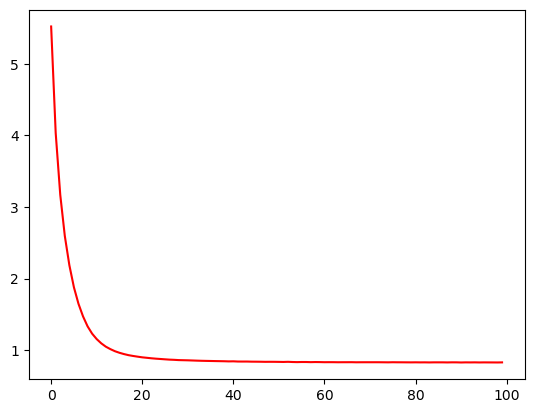

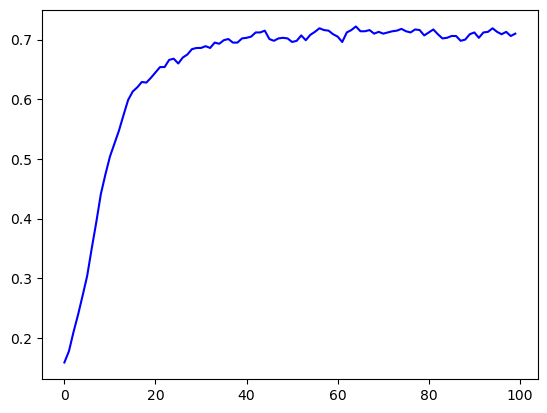

C:\Users\alber\anaconda3\envs\pyg_env\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\alber\anaconda3\envs\pyg_env\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


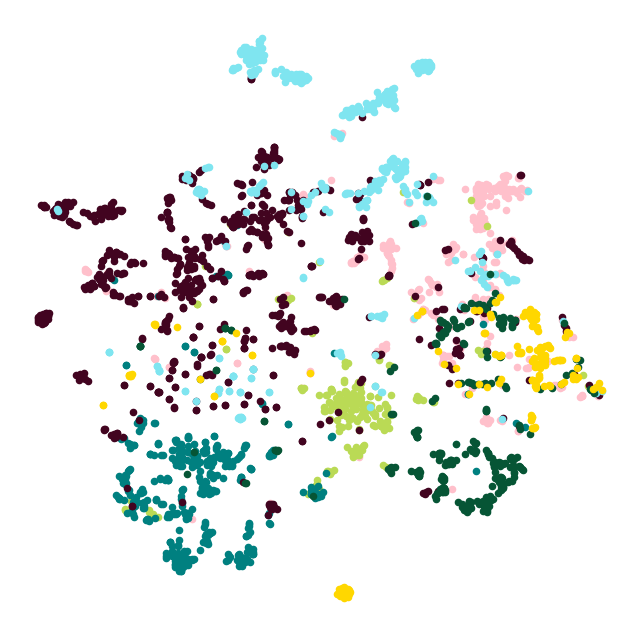

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=64, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

num_workers = 0
loader = model.loader(batch_size=128, shuffle=True, num_workers=num_workers)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)
    return acc

acc_values = []
loss_values = []
for epoch in range(1, 101):
    loss = train()
    acc = test()
    loss_values.append(loss)
    acc_values.append(acc)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')
    

plt.plot(loss_values, 'r',)
plt.show()
plt.plot(acc_values, 'b',)
plt.show()

@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(colors)

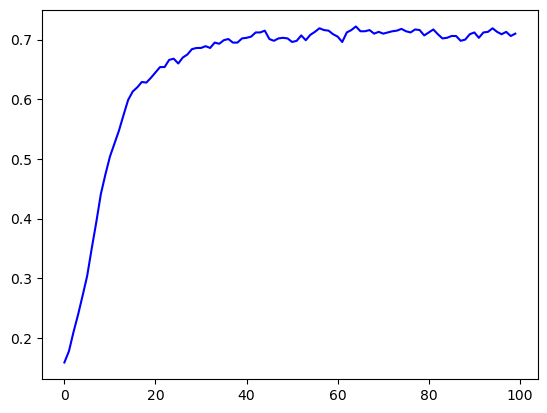

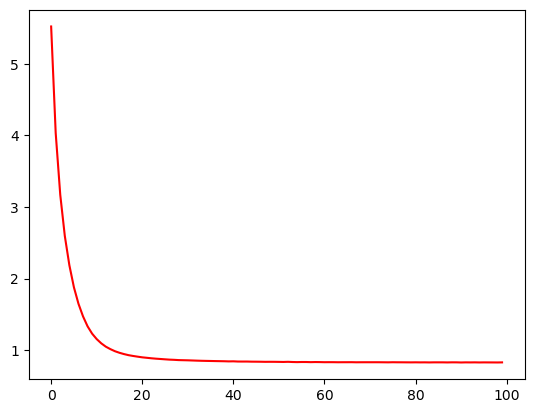

In [4]:
plt.plot(acc_values, 'b',)
plt.savefig('node2vec_acc_cora.png')
plt.show()

plt.plot(loss_values, 'r')
plt.savefig('node2vec_loss_cora.png')
plt.show()